# 네이버 영화리뷰 감성분석(Naver Movie Review Sentiment Classification)

Download the data using symbolic link.

In [1]:
!ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


Force the version of gensim to 3.8.3

In [2]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 24.2 MB 6.5 MB/s eta 0:00:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 1) 데이터 준비와 확인(Load and check the data)

In [3]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import Counter
import os

from konlpy.tag import Okt
import gensim


from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [4]:
gensim.__version__

'3.8.3'

In [5]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


위의 데이터만을 살펴보니 가장 먼저 드는 생각은 '재밓었다' 와 같은 오타의 처리는 어떤식으로 해야하는 지가 궁금해졌습니다. 비단 한국어에만 국한된 문제는 아니니 추후에 찾아보도록 하겠습니다.

- [ ] How to deal with typos?

## 2) 데이터로더 구성

### 2-1. 중복제거
중복제거를 하기 위한 코드 작성을 위해 pandas의 `drop_duplicates` 메소드를 사용하겠습니다. 당연할 수 있지만 'document' 컬럼에 대해 중복을 제거해주는 과정입니다. 당연한 사실을 다시금 `duplicated` 메소드를 통해 확인할 수 있습니다.

In [6]:
print("Duplicated IDs: ", len(train_data[train_data.duplicated(['id'])]))
print("Duplicated Docs: ", len(train_data[train_data.duplicated(['document'])]))

Duplicated IDs:  0
Duplicated Docs:  3817


중복을 제거하는 코드는 다음과 같습니다.

`train_data.drop_duplicates(subset=['document'], inplace=True)`

`test_data.drop_duplicates(subset=['document'], inplace=True)`

### 2-2. 결측치제거

리뷰를 모아놓은 경우, 결측치에 해당하는 nan값을 가지고 있는 데이터를 전부 삭제하는 것으로 처리하겠습니다. 이번 경우 또한 당연할 수 있지만 nan값은 'document' 컬럼에만 존재하고 있습니다. 어찌됐든 결측치처리를 nan값이 존재하는 데이터 자체를 삭제할 것입니다.

만약 ID값이나 label값에 nan값이 존재한다면 무조건 삭제하는 것보다는 겹치지 않는 id와 직접 판단해 라벨링을 해줄 수 있을 것 같습니다.

*(참고로 확인해보면 document의 값은 NaN이지만 id값과 라벨값은 존재합니다.)*

In [7]:
train_data.loc[train_data['document'].isna()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


결측치를 제거하는 코드는 다음과 같습니다.

`train_data.dropna(how='any')`

`test_data.dropna(how='any')`

### 2-3 한국어 토크나이저로 토큰화, 불용어제거
KoNLPy(코엔엘파이)는 한국어 정보처리를 위한 파이썬 패키지입니다. 이중에서도 Mecab 클래스를 Tokenizer로 사용할 예정입니다. 우선은 형태소 단위의 분석을 위한 클래스라는 정도만 알아도 무방할 것 같습니다. 

자세한 설명은 [공식 문서](https://konlpy.org/ko/v0.5.2/api/konlpy.tag/#mecab-class)에서 찾아볼 수 있습니다.

토큰화를 진행 후 큰 의미가 없는 불용어를 제거해주겠습니다. 위 두 과정을 거친 코드는 다음과 같습니다.

```Python
X_train = []
for sentence in train_data['document]:
    temp_X = tokenizer.morphs(sentence)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
```

### 2-4 사전 `word_to_index` 구성
>_IMDb 텍스트 데이터셋에 포함되어있는 `word_to_index`는 IMDb 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬되어 있습니다._

위와 같은 사실을 상기하며 사전 구성에 대해 생각해보겠습니다.
1. 우선 `np_concatenate`를 활용해 X_train 전체를 모은 뒤 리스트로 바꿔 words로 저장합니다.

2. Counter 모듈을 사용해 갯수를 파악하고 가장 빈번한 (10000-4)개를 찾습니다. 이는 10000개의 vocabulary로 이루어진 사전을 만들 예정이기 때문입니다. 4개를 빼준 이유는 각각 스페셜 토큰 `<PAD>`, `<BOS>`, `<UNK>`, `<UNUSED>`를 넣어주기 위함입니다.

3. 스페셜 토큰을 추가하고 word_to_index를 dictionary comprehension을 통해 만들어줍니다.

위 과정의 코드는 다음과 같습니다.

```Python
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4) 
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
```

### 2-5 텍스트 스트링을 사전 인덱스 스트링으로 변환

IMDb 데이터를 처음 읽었을 때 알파벳으로 이루어진 단어가 아닌 숫자값이 나왔습니다. 이처럼 데이터로더를 통해 텍스트 스트링을 사전 인덱스 스트링으로 변환할 수 있도록 하겠습니다.

1. 단어리스트를 인덱스리스트로 바꿔주는 함수를 만든다.
2. 기존에 저장해둔 X_train, X_test에 map을 이용해 함수를 적용한다.

위 과정의 코드는 다음과 같습니다.
```Python
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))
```

전체적인 데이터로더의 함수는 다음과 같이 구현할 수 있습니다.

In [8]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [9]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 2-6. Helper Function: Encoder, Decoder

단어 - 인덱스간 변환을 간편하게 해주는 함수를 만들어주겠습니다. 노드에서 구현한 방식 그대로 구현해주도록 하겠습니다.

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [12]:
rng = np.random.default_rng()
idx = rng.integers(0, len(X_train))
print(get_decoded_sentence(X_train[idx], index_to_word))
print('라벨: ', y_train[idx])  # 1번째 리뷰데이터의 라벨

<UNK> 드라마 로서 완성 높 수작
라벨:  1


## 3)  모델구성을 위한 데이터 분석 및 가공

### 3-1. 데이터셋 내 문장길이 분포, 적절한 최대 문장 길이 지정

In [13]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print(f"문장길이 평균: {np.mean(num_tokens)}")
print(f"문장길이 최대: {np.max(num_tokens)}")
print(f"문장길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen: ", maxlen)
print(f"전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens):.2%}가 maxlen 설정값 이내에 포함됩니다.")

문장길이 평균: 15.96940191154864
문장길이 최대: 116
문장길이 표준편차: 12.843571191092
pad_sequences maxlen:  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다.


### 3-2. `pad_sequences`을 활용한 패딩 추가

pre padding과 post padding을 각각 처리해 성능을 비교해보겠습니다.

#### 3-2-(1). pre-padding

In [14]:
pre_X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                         value=word_to_index["<PAD>"],
                                                         padding='pre',
                                                         maxlen=maxlen)

pre_X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)


print(pre_X_train.shape)
print(pre_X_test.shape)

(146182, 41)
(49157, 41)


In [15]:
pre_X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

#### 3-2-(2). post-padding

In [16]:
post_X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                          value=word_to_index["<PAD>"],
                                                          padding='post',
                                                          maxlen=maxlen)

post_X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                         value=word_to_index["<PAD>"],
                                                         padding='post',
                                                         maxlen=maxlen)


print(post_X_train.shape)
print(post_X_test.shape)

(146182, 41)
(49157, 41)


In [17]:
post_X_train[0]

array([ 32,  74, 919,   4,   4,  39, 228,  20,  33, 748,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

## 4) 모델구성 및 Validation set 구성

### 4-1. 모델구성(Subclassing)

In [381]:
class LSTMClf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size, word_vector_dim)
        self.rnn = keras.layers.LSTM(hidden_size)
        self.linear = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [382]:
vocab_size = 10000
word_vector_dim = 50
hidden_size = 16

clf = SimpeRNNClf(vocab_size, word_vector_dim , hidden_size)

In [383]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "simpe_rnn_clf_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     multiple                  500000    
_________________________________________________________________
lstm_25 (LSTM)               multiple                  4288      
_________________________________________________________________
dense_47 (Dense)             multiple                  17        
Total params: 504,305
Trainable params: 504,305
Non-trainable params: 0
_________________________________________________________________


### 4-2. Validation set 구성

sklearn의 `train_test_split`을 이용해 validation set을 구성해주겠습니다.

#### 4-2-(1). Validation for post_X_train

In [384]:
part_post_X_train, post_X_val, part_post_y_train, post_y_val = train_test_split(post_X_train, y_train, test_size=0.25)

In [385]:
print("part_post_X_train shape: ", part_post_X_train.shape)
print("part_post_y_train shape: ", part_post_y_train.shape)
print("post_X_val shape: ", post_X_val.shape)
print("post_y_val shape: ", post_y_val.shape)

part_post_X_train shape:  (109636, 41)
part_post_y_train shape:  (109636,)
post_X_val shape:  (36546, 41)
post_y_val shape:  (36546,)


#### 4-2-(2). Validation for pre_X_train

In [386]:
part_pre_X_train, pre_X_val, part_pre_y_train, pre_y_val = train_test_split(pre_X_train, y_train, test_size=0.3)

In [387]:
print("part_pre_X_train shape: ", part_pre_X_train.shape)
print("part_pre_y_train shape: ", part_pre_y_train.shape)
print("pre_X_val shape: ", pre_X_val.shape)
print("pre_y_val shape: ", pre_y_val.shape)

part_pre_X_train shape:  (102327, 41)
part_pre_y_train shape:  (102327,)
pre_X_val shape:  (43855, 41)
pre_y_val shape:  (43855,)


## 5) 모델 훈련, 시각화, Embedding layer 분석

훈련을 진행하며 사용할 callbacks를 우선 정의해주겠습니다.

In [391]:
file_name = "weights.epoch{epoch:02d}-val_acc{val_accuracy:.2f}.hdf5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', file_name),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)

### 5-1. Training for part_post_X_train (post-padding data)

In [392]:
vocab_size = 10000
word_vector_dim = 32
hidden_size = 4

clf = LSTMClf(vocab_size, word_vector_dim , hidden_size)

In [393]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

post_history = clf.fit(part_post_X_train,
                       part_post_y_train,
                       epochs=epochs,
                       batch_size=256,
                       validation_data=(post_X_val, post_y_val),
                       callbacks=[model_checkpoint_callback,
                                  early_stopping],
                       verbose=1)

Epoch 1/15
429/429 [==============================] - 7s 11ms/step - loss: 0.6095 - accuracy: 0.6849 - val_loss: 0.5598 - val_accuracy: 0.7513
Epoch 2/15
429/429 [==============================] - 4s 10ms/step - loss: 0.5506 - accuracy: 0.7536 - val_loss: 0.5444 - val_accuracy: 0.7507
Epoch 3/15
429/429 [==============================] - 4s 10ms/step - loss: 0.5297 - accuracy: 0.7685 - val_loss: 0.5283 - val_accuracy: 0.7769
Epoch 4/15
429/429 [==============================] - 4s 10ms/step - loss: 0.5282 - accuracy: 0.7724 - val_loss: 0.4874 - val_accuracy: 0.7861
Epoch 5/15
429/429 [==============================] - 4s 10ms/step - loss: 0.4307 - accuracy: 0.8151 - val_loss: 0.3809 - val_accuracy: 0.8348
Epoch 6/15
429/429 [==============================] - 4s 10ms/step - loss: 0.3234 - accuracy: 0.8653 - val_loss: 0.3765 - val_accuracy: 0.8380
Epoch 7/15
429/429 [==============================] - 4s 10ms/step - loss: 0.2870 - accuracy: 0.8822 - val_loss: 0.3698 - val_accuracy: 0.8420

### 5-2. Checking and Visualizing for part_post_X_train (post-padding data)

In [394]:
results = clf.evaluate(post_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4307 - accuracy: 0.8355
[0.4307456612586975, 0.8355066180229187]


In [395]:
post_history_dict = post_history.history
print(post_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


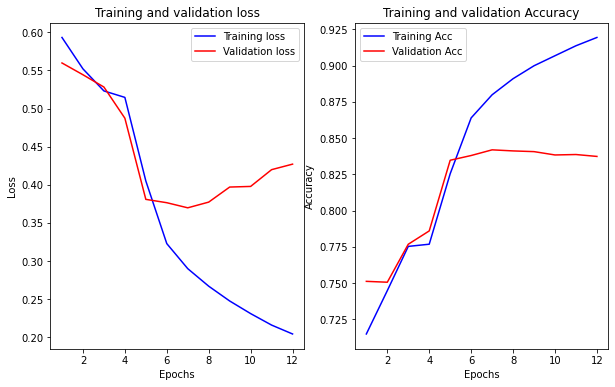

In [396]:
acc = post_history_dict['accuracy']
val_acc = post_history_dict['val_accuracy']
loss = post_history_dict['loss']
val_loss = post_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


Overfitting이 심한 모습을 보입니다. Embedding layer에 대한 분석이 끝난 뒤, LSTM 내부 옵션에 dropout을 추가해보도록 하겠습니다.

### 5-3. Training for part_pre_X_train (pre-padding data)

In [397]:
vocab_size = 10000
word_vector_dim = 32
hidden_size = 4

clf = LSTMClf(vocab_size, word_vector_dim , hidden_size)

In [399]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

pre_history = clf.fit(part_pre_X_train,
                      part_pre_y_train,
                      epochs=epochs,
                      batch_size=256,
                      validation_data=(pre_X_val, pre_y_val),
                      callbacks=[model_checkpoint_callback,
                                 early_stopping],
                      verbose=1)

Epoch 1/10
400/400 [==============================] - 6s 11ms/step - loss: 0.4579 - accuracy: 0.7837 - val_loss: 0.3520 - val_accuracy: 0.8460
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2969 - accuracy: 0.8759 - val_loss: 0.3503 - val_accuracy: 0.8494
Epoch 3/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2511 - accuracy: 0.8984 - val_loss: 0.3551 - val_accuracy: 0.8486
Epoch 4/10
400/400 [==============================] - 4s 10ms/step - loss: 0.2186 - accuracy: 0.9131 - val_loss: 0.3852 - val_accuracy: 0.8458
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1920 - accuracy: 0.9260 - val_loss: 0.4174 - val_accuracy: 0.8372
Epoch 6/10
400/400 [==============================] - 4s 10ms/step - loss: 0.1750 - accuracy: 0.9331 - val_loss: 0.4304 - val_accuracy: 0.8405


### 5-4. Checking and Visualizing for part_pre_X_train (pre-padding data)

In [400]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4234 - accuracy: 0.8399
[0.42336034774780273, 0.8399210572242737]


In [401]:
pre_history_dict = pre_history.history
print(pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


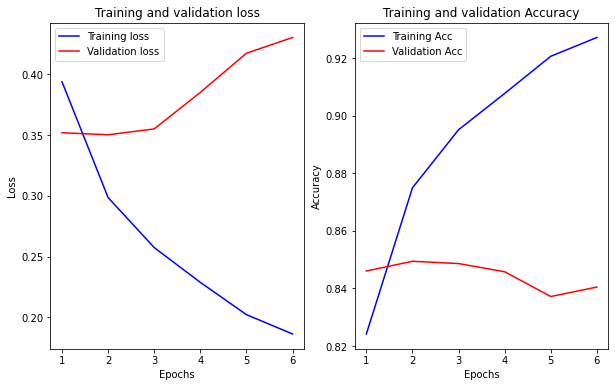

In [402]:
acc = pre_history_dict['accuracy']
val_acc = pre_history_dict['val_accuracy']
loss = pre_history_dict['loss']
val_loss = pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


### 5-5 Analysis of Embedding layer.

Embedding 레이어에 학습된 우리의 워드 벡터들을 분석하고 저장해보겠습니다. 워드 벡터를 다루는데 유용한 `gensim` 패키지의 버전을 확인하고 사용해보겠습니다.

In [35]:
!mkdir -p ~/aiffel/sentiment_classification/data
!pip list | grep gensim

gensim                        3.8.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [403]:
embedding_layer = clf.embedding
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 32)


In [404]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write(f"{vocab_size-4} {word_vector_dim}\n")

vectors = weights
for i in range(4,vocab_size):
    f.write(f"{index_to_word[i]} {' '.join(map(str, list(vectors[i, :])))}\n")
f.close()

In [405]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [406]:
word_vectors.similar_by_word("사랑", topn=5)

[('오염', 0.9166648387908936),
 ('이주승', 0.9163901805877686),
 ('세밀', 0.9085160493850708),
 ('통쾌', 0.8999670147895813),
 ('로렌스', 0.8973360657691956)]

In [407]:
word_list = list(index_to_word.values())
word_list = word_list[4:] ## exclude special tokens.

In [408]:
rng = np.random.default_rng()
idxs = rng.choice(len(word_list), 5)

for idx in idxs:
    print(f"{word_list[idx]} is similar with, ")
    print(word_vectors.similar_by_word(word_list[idx], topn=5))
    print('\n')

설레이 is similar with, 
[('힐러리', 0.9283785820007324), ('마이크', 0.9258052706718445), ('다룬', 0.8857613801956177), ('이자벨', 0.8808763027191162), ('마징가', 0.8807421326637268)]


둔갑 is similar with, 
[('맥빠지', 0.9481621980667114), ('판정', 0.9470293521881104), ('똥칠', 0.947012186050415), ('꽥꽥', 0.9437218904495239), ('맞출', 0.9378981590270996)]


사람 is similar with, 
[('편', 0.8422933220863342), ('한국', 0.7722507119178772), ('보고', 0.765798807144165), ('충만', 0.7642502784729004), ('무', 0.7598626613616943)]


뒤집 is similar with, 
[('알파치노', 0.8526536822319031), ('과학', 0.8473118543624878), ('피우', 0.8409221172332764), ('봐도', 0.8371709585189819), ('에디', 0.8363803625106812)]


퇴마 is similar with, 
[('08', 0.8489691019058228), ('색히', 0.8342427015304565), ('파티', 0.8272818326950073), ('허전', 0.8230529427528381), ('흘러가', 0.8222411870956421)]




"사랑"과 의미가 비슷한 단어를 잘 찾지 못하는 모습입니다. 또한 무작위로 확인해보면 잘 찾지 못하는 더 많은 경우를 확인할 수 있습니다.

## 6. Pre-trained 한국어 Word2Vec (pre-padding 데이터 이용)

In [409]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [410]:
vector = word2vec['강아지']
vector.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

In [411]:
word2vec.wv.most_similar('강아지')

[('고양이', 0.7290452718734741),
 ('거위', 0.7185635566711426),
 ('토끼', 0.7056223154067993),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.6934334635734558),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.6750352382659912),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512460708618164)]

In [412]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [413]:
embedding_matrix.shape

(10000, 200)

In [414]:
from tensorflow.keras.initializers import Constant

class w2vLSTMClf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        self.rnn = keras.layers.LSTM(hidden_size)
        self.linear = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [418]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 4

clf = w2vLSTMClf(vocab_size, word_vector_dim, hidden_size)

In [419]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_lstm_clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     multiple                  2000000   
_________________________________________________________________
lstm_30 (LSTM)               multiple                  3280      
_________________________________________________________________
dense_52 (Dense)             multiple                  5         
Total params: 2,003,285
Trainable params: 2,003,285
Non-trainable params: 0
_________________________________________________________________


In [420]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback,
                                     early_stopping],
                          verbose=1)

Epoch 1/10
400/400 [==============================] - 10s 22ms/step - loss: 0.4827 - accuracy: 0.7660 - val_loss: 0.3816 - val_accuracy: 0.8336
Epoch 2/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3312 - accuracy: 0.8578 - val_loss: 0.3867 - val_accuracy: 0.8308
Epoch 3/10
400/400 [==============================] - 7s 18ms/step - loss: 0.3090 - accuracy: 0.8698 - val_loss: 0.3914 - val_accuracy: 0.8316
Epoch 4/10
400/400 [==============================] - 7s 18ms/step - loss: 0.2926 - accuracy: 0.8775 - val_loss: 0.3963 - val_accuracy: 0.8324
Epoch 5/10
400/400 [==============================] - 7s 18ms/step - loss: 0.2826 - accuracy: 0.8827 - val_loss: 0.4025 - val_accuracy: 0.8305
Epoch 6/10
400/400 [==============================] - 7s 18ms/step - loss: 0.2794 - accuracy: 0.8848 - val_loss: 0.4112 - val_accuracy: 0.8274


In [421]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4087 - accuracy: 0.8275
[0.4087352156639099, 0.8274508118629456]


In [422]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


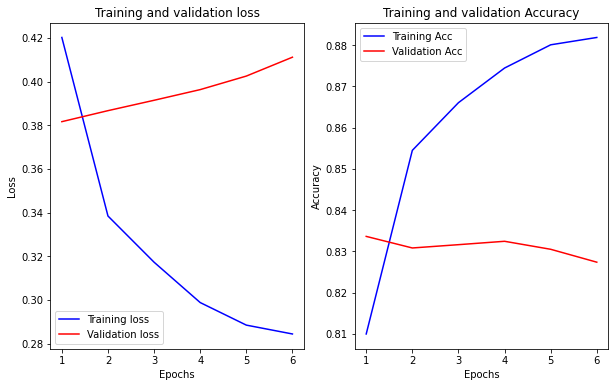

In [423]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


이번에도 극심한 overfitting을 보입니다.

### 6-2. Analysis of Embedding layer.

In [424]:
embedding_layer = clf.embedding
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 200)


In [425]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write(f"{vocab_size-4} {word_vector_dim}\n")

vectors = weights
for i in range(4,vocab_size):
    f.write(f"{index_to_word[i]} {' '.join(map(str, list(vectors[i, :])))}\n")
f.close()

In [426]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [427]:
word_vectors.similar_by_word("사랑", topn=5)

[('슬픔', 0.6957734823226929),
 ('행복', 0.6853253841400146),
 ('이별', 0.6808498501777649),
 ('감동', 0.673057496547699),
 ('그리움', 0.6445170044898987)]

In [428]:
word_list = list(index_to_word.values())
word_list = word_list[4:] ## exclude special tokens.

In [429]:
rng = np.random.default_rng()
idxs = rng.choice(len(word_list), 5)

for idx in idxs:
    print(f"{word_list[idx]} is similar with, ")
    print(word_vectors.similar_by_word(word_list[idx], topn=5))
    print('\n')

후속작 is similar with, 
[('다죠', 0.7879760265350342), ('느와르', 0.7761842012405396), ('카메론', 0.7728991508483887), ('샀', 0.7656666040420532), ('하루하루', 0.7625722885131836)]


잡아먹 is similar with, 
[('먹', 0.6990151405334473), ('속이', 0.6070582866668701), ('먹이', 0.6047545671463013), ('물고기', 0.6038870215415955), ('좋아하', 0.5830245018005371)]


늙 is similar with, 
[('죽', 0.6356596946716309), ('몹시', 0.5436425805091858), ('어리석', 0.5381615161895752), ('고생', 0.5196002721786499), ('무서워하', 0.5171804428100586)]


재발견 is similar with, 
[('매혹', 0.6608326435089111), ('전해', 0.6021566390991211), ('후편', 0.5897393822669983), ('성찰', 0.5789394378662109), ('고인', 0.5595855116844177)]


유도 is similar with, 
[('조절', 0.5278421640396118), ('조작', 0.4705233871936798), ('주입', 0.4677167236804962), ('유발', 0.4234807789325714), ('권장', 0.41807466745376587)]




"사랑"에 대한 분류는 이전의 embedding layer보다는 잘 학습하고 있습니다. 아직도 의미를 잘 파악하지 못한 단어들이 종종 있지만 이전과 비교하면 꽤나 잘 찾고 있습니다.

* 임베딩 시각화(우수노드 참고)

## 7. How to avoid overfitting

지금까지의 학습결과를 보면 어떤 모델을 사용하고 어떤 패딩을 사용해도 5 epoch 안으로 train data에 대해서는 학습을 성공적으로 해버리고 결과적으로는 overfitting의 문제를 겪고 있습니다.

overfitting을 해결하는 다양한 방법이 있습니다. 간단하게는 모델의 구조를 간단하게 만들어주는 방법이 있습니다. 하지만 이미 LSTM의 hidden_size를 4로 충분히 작게 해줬습니다. 

이 과정은 엄청 길고 다양한 시도를 했습니다. 아래 링크를 통하면 정확도를 만족한 경우로 바로 이동할 수 있습니다.

1. [Dropout + L2 Regularizer with 8 units LSTM](#success1)

### 7-1. Dropout

이를 피하기 위한 첫번째 방법으로 Dropout을 사용해보겠습니다. 지금까지 구현해본 MLP, CNN 등에서는 keras의 Dropout 레이어를 직접 추가해주는 방법으로 사용해왔습니다.

하지만 RNN계열의 LSTM에서는 다른 방식으로 사용해야합니다. 이는 dropout이 지워버리면 안되는 과거의 정보까지 모두 지워버리기 때문입니다. 이를 해결하기 위해 과거로부터 정보를 받아들이는 recurrent connection이 아닌 다음 레이어로 보내주는 connection에 대해서만 dropout을 적용해줘야 합니다. 자세한 설명은 다음의 링크와 논문으로 대체하겠습니다.

[reference1](http://sanghyukchun.github.io/89/)
[reference2](https://arxiv.org/abs/1409.2329)

감사하게도 이 기능은 keras의 LSTM 레이어에 파라미터로 제공되고 있습니다. 이 방법과 pre-trained Word2Vec 임베딩 레이어를 활용해 학습을 진행해보겠습니다.

In [430]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [431]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [436]:
from tensorflow.keras.initializers import Constant

class w2vLSTMregClf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        self.rnn = keras.layers.LSTM(hidden_size, dropout=0.5)
        self.linear = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [437]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 4

clf = w2vLSTMregClf(vocab_size, word_vector_dim, hidden_size)

In [438]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_lst_mreg_clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     multiple                  2000000   
_________________________________________________________________
lstm_32 (LSTM)               multiple                  3280      
_________________________________________________________________
dense_54 (Dense)             multiple                  5         
Total params: 2,003,285
Trainable params: 2,003,285
Non-trainable params: 0
_________________________________________________________________


In [439]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

Epoch 1/10
400/400 [==============================] - 10s 22ms/step - loss: 0.5572 - accuracy: 0.6993 - val_loss: 0.3927 - val_accuracy: 0.8271
Epoch 2/10
400/400 [==============================] - 8s 20ms/step - loss: 0.3812 - accuracy: 0.8330 - val_loss: 0.3803 - val_accuracy: 0.8339
Epoch 3/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3455 - accuracy: 0.8543 - val_loss: 0.3810 - val_accuracy: 0.8350
Epoch 4/10
400/400 [==============================] - 7s 19ms/step - loss: 0.3353 - accuracy: 0.8568 - val_loss: 0.3817 - val_accuracy: 0.8357
Epoch 5/10
400/400 [==============================] - 7s 18ms/step - loss: 0.3253 - accuracy: 0.8615 - val_loss: 0.3818 - val_accuracy: 0.8371
Epoch 6/10
400/400 [==============================] - 7s 18ms/step - loss: 0.3174 - accuracy: 0.8664 - val_loss: 0.3842 - val_accuracy: 0.8385
Epoch 7/10
400/400 [==============================] - 7s 18ms/step - loss: 0.3119 - accuracy: 0.8675 - val_loss: 0.3837 - val_accuracy: 0.836

In [440]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3825 - accuracy: 0.8360
[0.3825221359729767, 0.8359948992729187]


In [441]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


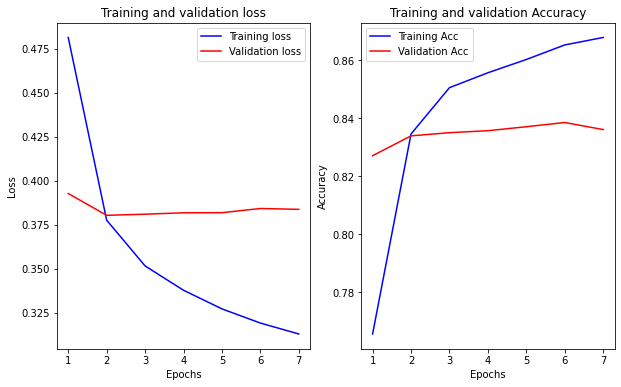

In [442]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


Overfitting이 조금 완화된 모습을 보입니다.

## 7-2. Dropout + L2 Regularizer

In [443]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras import regularizers

class w2vRLSTMreg_2Clf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        self.rnn = keras.layers.LSTM(hidden_size, dropout=0.5, kernel_regularizer=regularizers.l2(1e-3))
        self.linear = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-3))
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [445]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 4

clf = w2vRLSTMreg_2Clf(vocab_size, word_vector_dim, hidden_size)

In [446]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_rlst_mreg_2_clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     multiple                  2000000   
_________________________________________________________________
lstm_34 (LSTM)               multiple                  3280      
_________________________________________________________________
dense_56 (Dense)             multiple                  5         
Total params: 2,003,285
Trainable params: 2,003,285
Non-trainable params: 0
_________________________________________________________________


In [447]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

Epoch 1/10
400/400 [==============================] - 10s 22ms/step - loss: 0.5571 - accuracy: 0.7236 - val_loss: 0.4049 - val_accuracy: 0.8367
Epoch 2/10
400/400 [==============================] - 8s 20ms/step - loss: 0.3919 - accuracy: 0.8434 - val_loss: 0.3907 - val_accuracy: 0.8434
Epoch 3/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3608 - accuracy: 0.8571 - val_loss: 0.3895 - val_accuracy: 0.8443
Epoch 4/10
400/400 [==============================] - 7s 19ms/step - loss: 0.3429 - accuracy: 0.8643 - val_loss: 0.3946 - val_accuracy: 0.8404
Epoch 5/10
400/400 [==============================] - 7s 18ms/step - loss: 0.3325 - accuracy: 0.8711 - val_loss: 0.3905 - val_accuracy: 0.8445
Epoch 6/10
400/400 [==============================] - 7s 18ms/step - loss: 0.3210 - accuracy: 0.8763 - val_loss: 0.3976 - val_accuracy: 0.8436
Epoch 7/10
400/400 [==============================] - 7s 18ms/step - loss: 0.3181 - accuracy: 0.8786 - val_loss: 0.3921 - val_accuracy: 0.844

In [448]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3893 - accuracy: 0.8444
[0.3892527222633362, 0.8443558216094971]


In [449]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


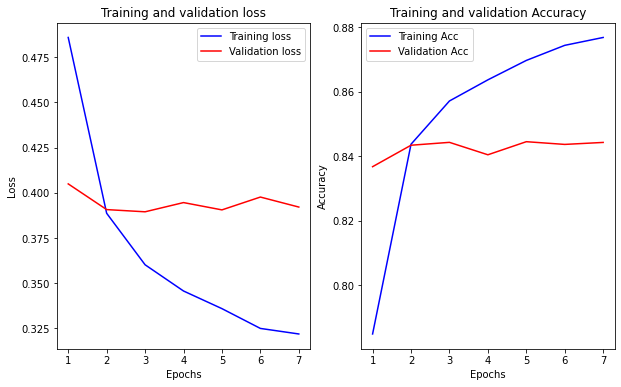

In [450]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


<a id='success1'></a>

### More complex version

In [520]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 8

clf = w2vRLSTMreg_2Clf(vocab_size, word_vector_dim, hidden_size)

In [521]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_rlst_mreg_2_clf_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embedding)     multiple                  2000000   
_________________________________________________________________
lstm_35 (LSTM)               multiple                  6688      
_________________________________________________________________
dense_68 (Dense)             multiple                  9         
Total params: 2,006,697
Trainable params: 2,006,697
Non-trainable params: 0
_________________________________________________________________


In [522]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

Epoch 1/10
400/400 [==============================] - 11s 22ms/step - loss: 0.5557 - accuracy: 0.7367 - val_loss: 0.4114 - val_accuracy: 0.8387
Epoch 2/10
400/400 [==============================] - 8s 20ms/step - loss: 0.3895 - accuracy: 0.8498 - val_loss: 0.3872 - val_accuracy: 0.8458
Epoch 3/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3583 - accuracy: 0.8617 - val_loss: 0.3895 - val_accuracy: 0.8503
Epoch 4/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3427 - accuracy: 0.8710 - val_loss: 0.3876 - val_accuracy: 0.8470
Epoch 5/10
400/400 [==============================] - 7s 19ms/step - loss: 0.3317 - accuracy: 0.8764 - val_loss: 0.3874 - val_accuracy: 0.8498
Epoch 6/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3251 - accuracy: 0.8805 - val_loss: 0.3891 - val_accuracy: 0.8505
Epoch 7/10
400/400 [==============================] - 7s 19ms/step - loss: 0.3174 - accuracy: 0.8845 - val_loss: 0.3888 - val_accuracy: 0.851

In [523]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3892 - accuracy: 0.8502
[0.38917940855026245, 0.8502349853515625]


## <span style="color:Red">**85%**</span>를 달성했습니다.

In [526]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


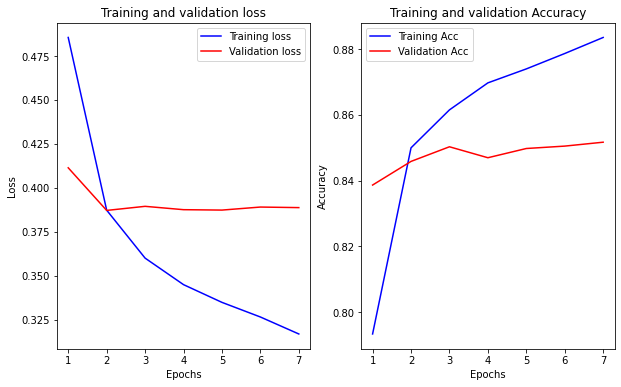

In [527]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


### Analysis of Embedding layer.

In [546]:
embedding_layer = clf.embedding
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 200)


In [547]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write(f"{vocab_size-4} {word_vector_dim}\n")

vectors = weights
for i in range(4,vocab_size):
    f.write(f"{index_to_word[i]} {' '.join(map(str, list(vectors[i, :])))}\n")
f.close()

In [548]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [549]:
word_vectors.similar_by_word("사랑", topn=5)

[('슬픔', 0.7121944427490234),
 ('행복', 0.655667781829834),
 ('추억', 0.6312143802642822),
 ('그대', 0.6142654418945312),
 ('연인', 0.6076455116271973)]

In [550]:
word_list = list(index_to_word.values())
word_list = word_list[4:] ## exclude special tokens.

In [551]:
rng = np.random.default_rng()
idxs = rng.choice(len(word_list), 5)

for idx in idxs:
    print(f"{word_list[idx]} is similar with, ")
    print(word_vectors.similar_by_word(word_list[idx], topn=5))
    print('\n')

래쉬 is similar with, 
[('워크', 0.40713775157928467), ('워터', 0.40117648243904114), ('댄싱', 0.3821157217025757), ('파워', 0.3754717707633972), ('울트라', 0.37475576996803284)]


개신교 is similar with, 
[('기독교', 0.5616400241851807), ('선교', 0.5523306727409363), ('교회', 0.530353844165802), ('설교', 0.4649898409843445), ('유태인', 0.44684547185897827)]


구혜선 is similar with, 
[('데미', 0.6864709854125977), ('Z', 0.6791378855705261), ('But', 0.6707404255867004), ('슬랩스틱', 0.6593992710113525), ('-_-;;', 0.6572587490081787)]


무엇 is similar with, 
[('그것', 0.5363345146179199), ('어떤', 0.5300086736679077), ('당신', 0.5004176497459412), ('누구', 0.49730029702186584), ('얼마나', 0.4747236967086792)]


홀딱 is similar with, 
[('시린', 0.773556113243103), ('감회', 0.7697162628173828), ('메이퀸', 0.7688419818878174), ('86', 0.7667218446731567), ('임다', 0.7630219459533691)]




#### Visualization
임베딩을 시각화해 표현해보겠습니다. 다음 두 링크를 참조했습니다.
[reference1](https://github.com/t1seo/AIFFEL/blob/master/EXPLORATION/05/[E-05]celebrity_look-a-like.ipynb)
[refenrence2](https://joyhong.tistory.com/133)

In [560]:
vector = word_vectors.wv.vocab
vocab = list(vector)
X = word_vectors[vocab]

sz = 500
X_show = X[:sz,:] 
vocab_show = vocab[:sz]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 't-SNE feature 1')

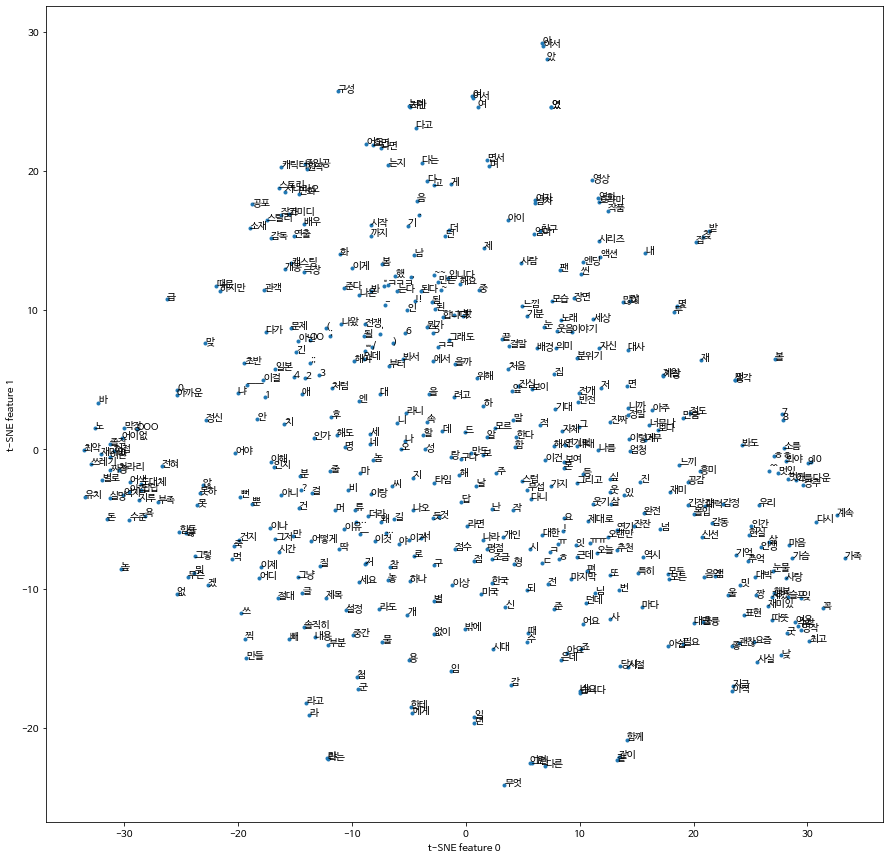

In [562]:
from sklearn.manifold import TSNE
import scipy as sp
import matplotlib as mpl

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams["axes.unicode_minus"] = False

plt.rc('font', family='NanumBarunGothic') # Nanum 폰트

tsne = TSNE(n_components=2, learning_rate=100, perplexity=15, random_state=0)
X = tsne.fit_transform(X_show) # 학습 및 변환

df = pd.DataFrame(X, index=vocab_show, columns=['x', 'y'])

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(df['x'], df['y'], marker='.')

for word, pos in df.iterrows(): 
    ax.annotate(word, pos, fontsize=10)

ax.set_xlabel("t-SNE feature 0")
ax.set_ylabel("t-SNE feature 1")

# cb = plt.colorbar(fig, ticks=range(10))
# n_clusters = 10
# tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
# cb.set_ticks(tick_locs)
# cb.set_ticklabels(range(10))



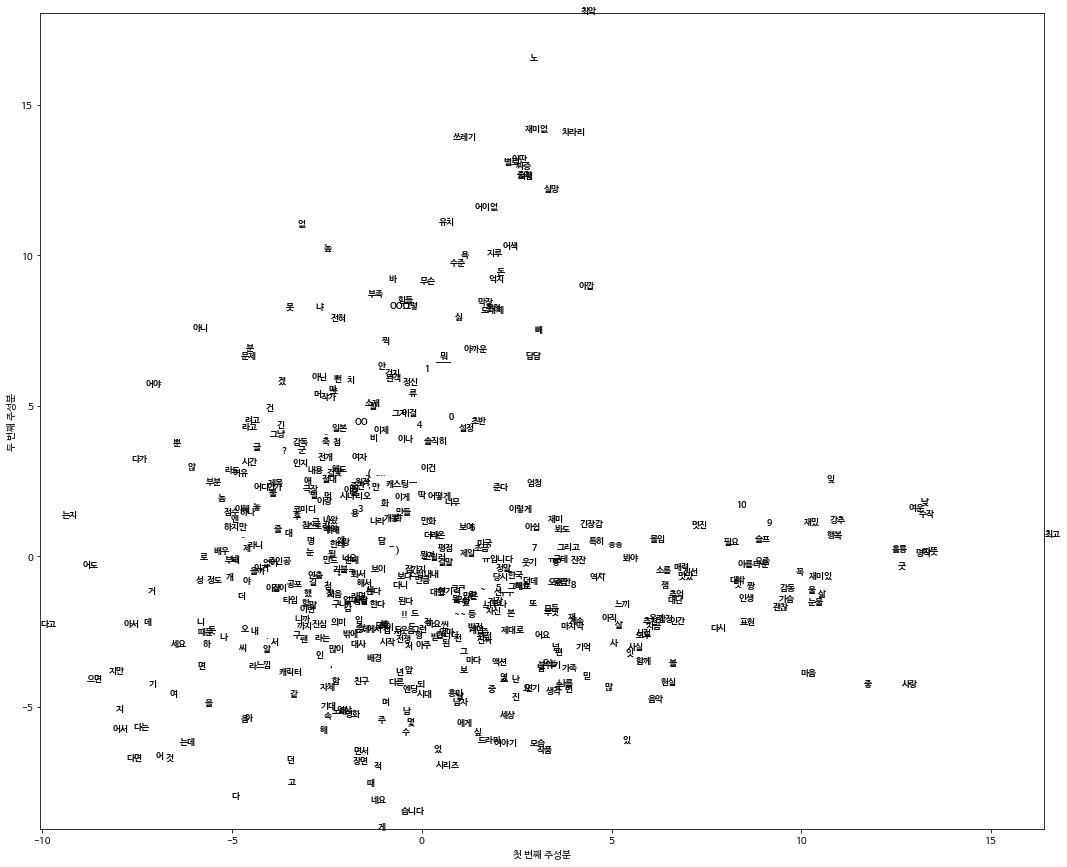

In [563]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
pca.fit(X_show) 
# 처음 두 개의 주성분으로 숫자 데이터를 변환합니다 
x_pca = pca.transform(X_show) 
plt.figure(figsize=(18, 15)) 
plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max()) 
plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max()) 

for i in range(len(X_show)): 
    plt.text(x_pca[i, 0], x_pca[i, 1], str(vocab_show[i]), 
             fontdict={'weight': 'bold', 'size': 9}) 

plt.xlabel("첫 번째 주성분") 
plt.ylabel("두 번째 주성분") 
plt.show()

### Confusion matrix

Text(33.0, 0.5, 'True')

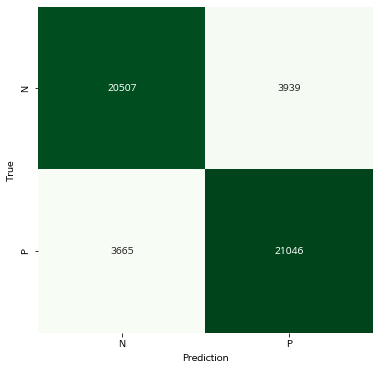

In [610]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#y_pred = clf.predict(pre_X_test)
y_pred = [0 if pred < 0.5 else 1 for pred in y_pred]
c_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(c_matrix, annot=True, xticklabels=['N', 'P'],
            yticklabels=['N', 'P'], 
            cbar=False, cmap='Greens', fmt='g', ax=ax)

ax.set_xlabel("Prediction")
ax.set_ylabel("True")


In [613]:
false_negatives = [] 
false_positives = []

for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        if y_test[i] == 0: # FP: False Positive
            false_positives.append(i)
        else: # FN
            false_negatives.append(i)

In [625]:
false_negatives[66]

790

In [626]:
FN = get_decoded_sentence(X_test[790], index_to_word)
print(FN)

싫 지만 영화 도대체 싫 어 할 수 없 다 .


In [624]:
false_positives[66]

875

In [627]:
FP = get_decoded_sentence(X_test[66], index_to_word)
print(FP)

번 을 봐도 볼 때 마다 재밌 다


## 7-3. LayerNorm

Overfitting을 피하기 위한 방법 중 MLP, CNN에서 사용하는 BatchNormalization(BN)을 RNN에 적용해보겠습니다. 아쉽게도 BN도 RNN에서 바로 적용할 수는 없습니다.

BN은 Batch 별로 평균, 표준편차들의 통계량을 계산해 normalization을 해 학습을 효과적으로 하게 하는 방법입니다. 하지만 이는 RNN에서 중요한 recurrent 부분을 고려하지 않게 되고, Weight가 공유되는 RNN의 특성상 다른 통계적 특성을 보일 것입니다.

따라서 이를 해결하기 위해 Layer Normalization이라는 방법을 사용하게 됩니다. 이 또한 자세한 설명은 아래 링크와 논문으로 대체하겠습니다.

[reference1](https://arxiv.org/abs/1607.06450)
[reference2](https://hugrypiggykim.com/2018/08/08/recurrent-batch-normalization/)

구현은 tensorflow의 [addon](https://www.tensorflow.org/addons/api_docs/python/tfa/rnn/LayerNormLSTMCell)을 이용해 구현할 수 있습니다. 

In [453]:
import tensorflow_addons as tfa

class w2vLSTMLNClf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        self.LSTMCell = tfa.rnn.LayerNormLSTMCell(hidden_size)
        self.rnn = keras.layers.RNN(self.LSTMCell)
        self.linear = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [455]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 4

clf = w2vLSTMLNClf(vocab_size, word_vector_dim, hidden_size)

In [456]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_lstmln_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     multiple                  2000000   
_________________________________________________________________
layer_norm_lstm_cell_19 (Lay multiple                  3352      
_________________________________________________________________
rnn_18 (RNN)                 multiple                  3352      
_________________________________________________________________
dense_58 (Dense)             multiple                  5         
Total params: 2,003,357
Trainable params: 2,003,357
Non-trainable params: 0
_________________________________________________________________


In [457]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

Epoch 1/10
400/400 [==============================] - 69s 164ms/step - loss: 0.5758 - accuracy: 0.6797 - val_loss: 0.3866 - val_accuracy: 0.8273
Epoch 2/10
400/400 [==============================] - 65s 162ms/step - loss: 0.3230 - accuracy: 0.8640 - val_loss: 0.3704 - val_accuracy: 0.8439
Epoch 3/10
400/400 [==============================] - 65s 163ms/step - loss: 0.3003 - accuracy: 0.8749 - val_loss: 0.3618 - val_accuracy: 0.8436
Epoch 4/10
400/400 [==============================] - 65s 163ms/step - loss: 0.2571 - accuracy: 0.8952 - val_loss: 0.3884 - val_accuracy: 0.8431
Epoch 5/10
400/400 [==============================] - 65s 162ms/step - loss: 0.2370 - accuracy: 0.9053 - val_loss: 0.3970 - val_accuracy: 0.8414
Epoch 6/10
400/400 [==============================] - 65s 163ms/step - loss: 0.2288 - accuracy: 0.9068 - val_loss: 0.4096 - val_accuracy: 0.8413
Epoch 7/10
400/400 [==============================] - 65s 163ms/step - loss: 0.2105 - accuracy: 0.9152 - val_loss: 0.4140 - val_ac

In [458]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 23s - loss: 0.4109 - accuracy: 0.8393
[0.4108758866786957, 0.8392701148986816]


In [459]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


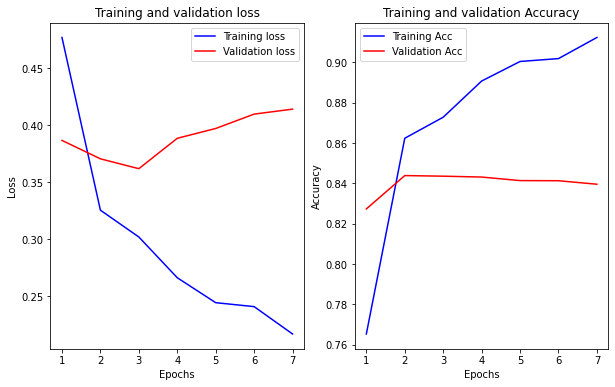

In [460]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


Overfitting을 아직도 보이고 있습니다. 일반적으로 BN을 사용하는 CNN, MLP의 경우에는 Dropout과 BN을 함께 사용하지는 않습니다. 실제로 여러개의 Regularization을 사용하면 성능 저하가 발생하기도 합니다. 

여기서는 조심스럽게 LayerNorm에 Kernel regularizer를 추가하는 것으로 시작해보겠습니다.

## 7-4. LayerNorm + Kernel regularizer

In [461]:
import tensorflow_addons as tfa

class w2vLSTMLNregClf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        self.LSTMCell = tfa.rnn.LayerNormLSTMCell(hidden_size, kernel_regularizer=regularizers.l2(0.01))
        self.rnn = keras.layers.RNN(self.LSTMCell)
        self.linear = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [462]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 4

clf = w2vLSTMLNregClf(vocab_size, word_vector_dim, hidden_size)

In [463]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_lstml_nreg_clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_59 (Embedding)     multiple                  2000000   
_________________________________________________________________
layer_norm_lstm_cell_20 (Lay multiple                  3352      
_________________________________________________________________
rnn_19 (RNN)                 multiple                  3352      
_________________________________________________________________
dense_59 (Dense)             multiple                  5         
Total params: 2,003,357
Trainable params: 2,003,357
Non-trainable params: 0
_________________________________________________________________


In [464]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

Epoch 1/15
200/200 [==============================] - 38s 178ms/step - loss: 0.7282 - accuracy: 0.6626 - val_loss: 0.4669 - val_accuracy: 0.8291
Epoch 2/15
200/200 [==============================] - 35s 175ms/step - loss: 0.4393 - accuracy: 0.8460 - val_loss: 0.4620 - val_accuracy: 0.8364
Epoch 3/15
200/200 [==============================] - 34s 171ms/step - loss: 0.4025 - accuracy: 0.8642 - val_loss: 0.4898 - val_accuracy: 0.8229
Epoch 4/15
200/200 [==============================] - 34s 169ms/step - loss: 0.6695 - accuracy: 0.7959 - val_loss: 0.4404 - val_accuracy: 0.8381
Epoch 5/15
200/200 [==============================] - 33s 167ms/step - loss: 0.3738 - accuracy: 0.8798 - val_loss: 0.4301 - val_accuracy: 0.8388
Epoch 6/15
200/200 [==============================] - 35s 174ms/step - loss: 0.3549 - accuracy: 0.8846 - val_loss: 0.4278 - val_accuracy: 0.8400
Epoch 7/15
200/200 [==============================] - 34s 172ms/step - loss: 0.3482 - accuracy: 0.8884 - val_loss: 0.4365 - val_ac

In [465]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 23s - loss: 0.5494 - accuracy: 0.8331
[0.5494190454483032, 0.8331264853477478]


In [466]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


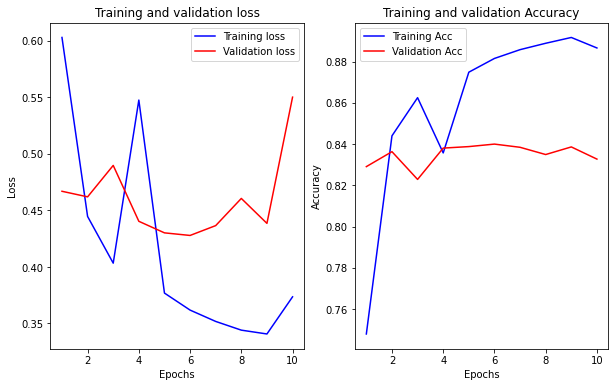

In [467]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


아직도 약간의 overfitting이 남아있는 관계로 dropout까지 합쳐서 진행해보겠습니다.

## 7-5. LayerNorm + Kernel regularizer + Dropout

In [483]:
import tensorflow_addons as tfa

class w2vLSTMLNreg_2Clf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        self.LSTMCell = tfa.rnn.LayerNormLSTMCell(hidden_size, kernel_regularizer=regularizers.l2(0.03), dropout=0.5)
        self.rnn = keras.layers.RNN(self.LSTMCell)
        self.linear = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.03))
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [484]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 4

clf = w2vLSTMLNreg_2Clf(vocab_size, word_vector_dim, hidden_size)

In [485]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_lstml_nreg_2_clf_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     multiple                  2000000   
_________________________________________________________________
layer_norm_lstm_cell_24 (Lay multiple                  3352      
_________________________________________________________________
rnn_23 (RNN)                 multiple                  3352      
_________________________________________________________________
dense_63 (Dense)             multiple                  5         
Total params: 2,003,357
Trainable params: 2,003,357
Non-trainable params: 0
_________________________________________________________________


In [486]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

Epoch 1/50
200/200 [==============================] - 41s 189ms/step - loss: 1.4267 - accuracy: 0.5273 - val_loss: 0.8459 - val_accuracy: 0.6063
Epoch 2/50
200/200 [==============================] - 37s 187ms/step - loss: 0.8290 - accuracy: 0.6478 - val_loss: 0.6005 - val_accuracy: 0.7883
Epoch 3/50
200/200 [==============================] - 37s 184ms/step - loss: 0.5796 - accuracy: 0.8104 - val_loss: 0.8501 - val_accuracy: 0.7563
Epoch 4/50
200/200 [==============================] - 36s 182ms/step - loss: 0.6434 - accuracy: 0.8147 - val_loss: 1.0067 - val_accuracy: 0.7671
Epoch 5/50
200/200 [==============================] - 36s 178ms/step - loss: 0.6946 - accuracy: 0.8215 - val_loss: 0.5227 - val_accuracy: 0.8291
Epoch 6/50
200/200 [==============================] - 36s 178ms/step - loss: 0.5033 - accuracy: 0.8548 - val_loss: 0.4822 - val_accuracy: 0.8382
Epoch 7/50
200/200 [==============================] - 37s 185ms/step - loss: 0.4616 - accuracy: 0.8613 - val_loss: 0.4967 - val_ac

In [487]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 24s - loss: 0.4978 - accuracy: 0.8285
[0.497842937707901, 0.828488290309906]


In [488]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


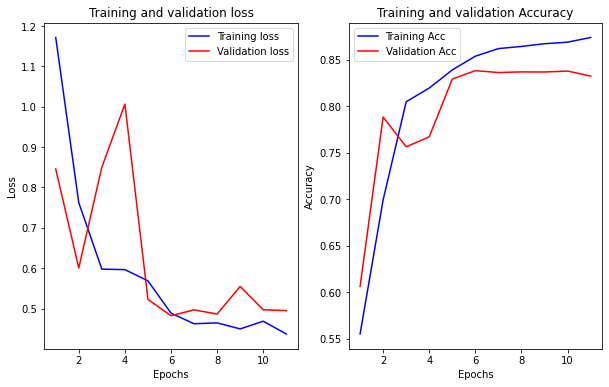

In [489]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


오버피팅이 발생하지 않지만 원하는 성능을 얻지 못했습니다. 모델의 복잡도를 조금 추가해 성능을 얻을 수 있는 지 확인해보겠습니다.

### More complex version

In [582]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 100

clf = w2vLSTMLNreg_2Clf(vocab_size, word_vector_dim, hidden_size)

In [583]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_lstml_nreg_2_clf_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_72 (Embedding)     multiple                  2000000   
_________________________________________________________________
layer_norm_lstm_cell_32 (Lay multiple                  122200    
_________________________________________________________________
rnn_31 (RNN)                 multiple                  122200    
_________________________________________________________________
dense_72 (Dense)             multiple                  101       
Total params: 2,122,301
Trainable params: 2,122,301
Non-trainable params: 0
_________________________________________________________________


In [584]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

Epoch 1/50
200/200 [==============================] - 45s 212ms/step - loss: 1.5574 - accuracy: 0.6909 - val_loss: 0.6051 - val_accuracy: 0.8194
Epoch 2/50
200/200 [==============================] - 41s 205ms/step - loss: 0.6000 - accuracy: 0.8279 - val_loss: 0.5709 - val_accuracy: 0.8220
Epoch 3/50
200/200 [==============================] - 41s 203ms/step - loss: 0.5451 - accuracy: 0.8447 - val_loss: 0.5269 - val_accuracy: 0.8404
Epoch 4/50
200/200 [==============================] - 45s 223ms/step - loss: 0.5242 - accuracy: 0.8521 - val_loss: 0.5155 - val_accuracy: 0.8416
Epoch 5/50
200/200 [==============================] - 45s 223ms/step - loss: 0.4779 - accuracy: 0.8599 - val_loss: 0.5199 - val_accuracy: 0.8374
Epoch 6/50
200/200 [==============================] - 44s 221ms/step - loss: 0.4686 - accuracy: 0.8642 - val_loss: 0.4908 - val_accuracy: 0.8468
Epoch 7/50
200/200 [==============================] - 42s 212ms/step - loss: 0.4537 - accuracy: 0.8674 - val_loss: 0.5047 - val_ac

In [585]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 23s - loss: 0.4970 - accuracy: 0.8453
[0.49698272347450256, 0.8453119397163391]


In [586]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


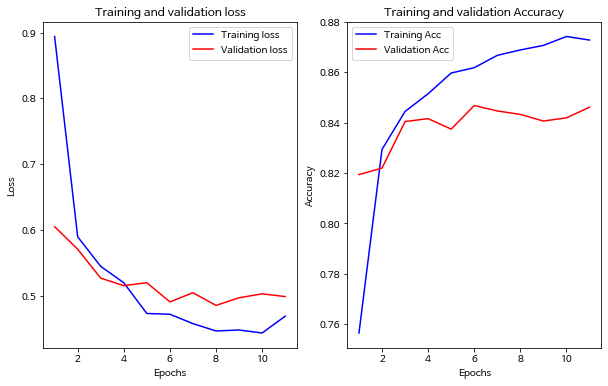

In [588]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


## 7-6. LayerNorm + Kernel regularizer + Dropout(Recurrent)

위에서 Dropout에서 Recurrent에 해당하는 부분은 버리지 않는다고 했습니다. 하지만 오버피팅을 피하기 위해 recurrent dropout을 도입해보겠습니다.

In [490]:
import tensorflow_addons as tfa

class w2vLSTMLNreg_3Clf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        self.LSTMCell = tfa.rnn.LayerNormLSTMCell(hidden_size, kernel_regularizer=regularizers.l2(0.02), 
                                                  dropout=0.5, recurrent_dropout=0.2)
        self.rnn = keras.layers.RNN(self.LSTMCell)
        self.linear = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.02))
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [491]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 4

clf = w2vLSTMLNreg_3Clf(vocab_size, word_vector_dim, hidden_size)

In [492]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_lstml_nreg_3_clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     multiple                  2000000   
_________________________________________________________________
layer_norm_lstm_cell_25 (Lay multiple                  3352      
_________________________________________________________________
rnn_24 (RNN)                 multiple                  3352      
_________________________________________________________________
dense_64 (Dense)             multiple                  5         
Total params: 2,003,357
Trainable params: 2,003,357
Non-trainable params: 0
_________________________________________________________________


In [493]:
opt = keras.optimizers.Adam(0.01)


clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=50

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

Epoch 1/50
400/400 [==============================] - 70s 168ms/step - loss: 0.8178 - accuracy: 0.6598 - val_loss: 0.8460 - val_accuracy: 0.7996
Epoch 2/50
400/400 [==============================] - 66s 164ms/step - loss: 0.6711 - accuracy: 0.8145 - val_loss: 0.4860 - val_accuracy: 0.8332
Epoch 3/50
400/400 [==============================] - 66s 165ms/step - loss: 0.5479 - accuracy: 0.8375 - val_loss: 0.4954 - val_accuracy: 0.8361
Epoch 4/50
400/400 [==============================] - 66s 165ms/step - loss: 0.4743 - accuracy: 0.8529 - val_loss: 1.1069 - val_accuracy: 0.6326
Epoch 5/50
400/400 [==============================] - 66s 164ms/step - loss: 0.8431 - accuracy: 0.7832 - val_loss: 0.5944 - val_accuracy: 0.8219
Epoch 6/50
400/400 [==============================] - 66s 164ms/step - loss: 0.5920 - accuracy: 0.8252 - val_loss: 0.4760 - val_accuracy: 0.8387
Epoch 7/50
400/400 [==============================] - 66s 165ms/step - loss: 0.4385 - accuracy: 0.8632 - val_loss: 0.4835 - val_ac

In [494]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 23s - loss: 0.4860 - accuracy: 0.8356
[0.48603716492652893, 0.8355880379676819]


In [495]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


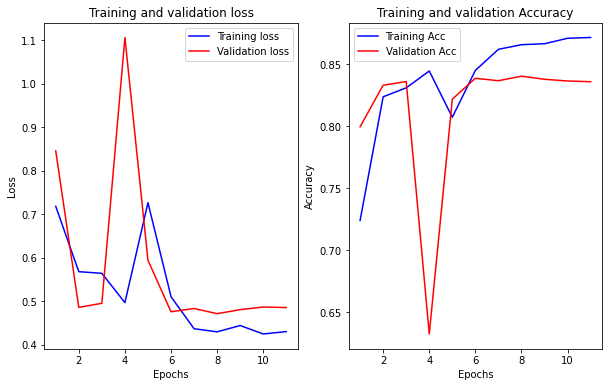

In [496]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


## 8. GRU

Overfitting을 피하는 가장 좋은 방법은 모델의 복잡도를 낮춰주는 방법입니다. 따라서 LSTM보다 복잡도가 낮은 GRU를 이용해 성능을 확인해보겠습니다.

In [355]:
from tensorflow.keras.initializers import Constant

class w2vGRUClf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        
        self.rnn = keras.layers.GRU(hidden_size)
        self.linear = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [ ]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 4

clf = w2vGRUClf(vocab_size, word_vector_dim, hidden_size)

In [ ]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

In [ ]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          callbacks=[model_checkpoint_callback, early_stopping],
                          verbose=1)

In [ ]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

In [ ]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

In [ ]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


## Conv1D

In [366]:
from tensorflow.keras.initializers import Constant

class conv1D_Clf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        
        self.conv1 = keras.layers.Conv1D(16, 7, activation='relu')
        self.pool1 = keras.layers.MaxPooling1D(5)
        self.conv2 = keras.layers.Conv1D(16, 7, activation='relu')
        self.pool2 = keras.layers.GlobalMaxPooling1D()
        self.linear1 = keras.layers.Dense(4, activation='relu')
        self.linear2 = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        
        out = self.embedding(x)
        out = self.conv1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.pool2(out)
        out = self.linear1(out)
        out = self.linear2(out)
        
        return out

In [367]:
vocab_size = 10000
word_vector_dim = 200

clf = conv1D_Clf(vocab_size, word_vector_dim)

In [368]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "conv1d__clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     multiple                  2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 multiple                  0         
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob multiple                  0         
_________________________________________________________________
dense_44 (Dense)             multiple                  68        
_________________________________________________________________
dense_45 (Dense)             multiple                

In [369]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          verbose=1)

Epoch 1/10
400/400 [==============================] - 13s 26ms/step - loss: 0.6983 - accuracy: 0.5048 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 2/10
400/400 [==============================] - 7s 18ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6934 - val_accuracy: 0.4984
Epoch 3/10
400/400 [==============================] - 7s 17ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5016
Epoch 4/10
400/400 [==============================] - 7s 17ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 5/10
400/400 [==============================] - 7s 17ms/step - loss: 0.6932 - accuracy: 0.5049 - val_loss: 0.6932 - val_accuracy: 0.5016
Epoch 6/10
400/400 [==============================] - 7s 17ms/step - loss: 0.6933 - accuracy: 0.4985 - val_loss: 0.6934 - val_accuracy: 0.4984
Epoch 7/10
400/400 [==============================] - 7s 17ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.501

In [370]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6932 - accuracy: 0.5027
[0.693228006362915, 0.5026954412460327]


In [371]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


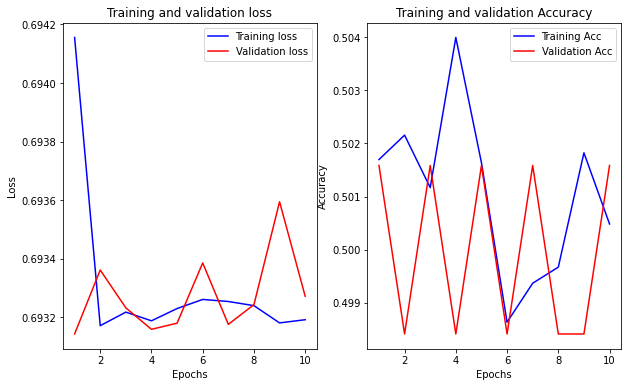

In [372]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


## SimpleRNN

In [373]:
from tensorflow.keras.initializers import Constant

class w2v_RNN_Clf(keras.Model):
    
    def __init__(self, vocab_size, word_vector_dim, hidden_size):
        super().__init__()
        
        self.embedding = keras.layers.Embedding(vocab_size,
                                                word_vector_dim,
                                                embeddings_initializer=Constant(embedding_matrix),
                                                input_length=maxlen,
                                                trainable=True)
        
        self.rnn = keras.layers.SimpleRNN(hidden_size)
        self.linear = keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn(out)
        out = self.linear(out)
        
        return out

In [375]:
vocab_size = 10000
word_vector_dim = 200
hidden_size = 8

clf = w2v_RNN_Clf(vocab_size, word_vector_dim, hidden_size)

In [376]:
input_shape = post_X_train.shape
clf.build(input_shape)
clf.summary()

Model: "w2v_rnn__clf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     multiple                  2000000   
_________________________________________________________________
simple_rnn (SimpleRNN)       multiple                  1672      
_________________________________________________________________
dense_46 (Dense)             multiple                  9         
Total params: 2,001,681
Trainable params: 2,001,681
Non-trainable params: 0
_________________________________________________________________


In [377]:
opt = keras.optimizers.Adam(0.01)

clf.compile(optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

w2v_pre_history = clf.fit(part_pre_X_train,
                          part_pre_y_train,
                          epochs=epochs,
                          batch_size=256,
                          validation_data=(pre_X_val, pre_y_val),
                          verbose=1)

Epoch 1/10
400/400 [==============================] - 15s 36ms/step - loss: 0.6323 - accuracy: 0.6395 - val_loss: 0.5203 - val_accuracy: 0.7582
Epoch 2/10
400/400 [==============================] - 14s 34ms/step - loss: 0.4910 - accuracy: 0.7784 - val_loss: 0.5044 - val_accuracy: 0.7691
Epoch 3/10
400/400 [==============================] - 14s 35ms/step - loss: 0.4657 - accuracy: 0.7930 - val_loss: 0.4916 - val_accuracy: 0.7766
Epoch 4/10
400/400 [==============================] - 14s 34ms/step - loss: 0.4546 - accuracy: 0.7979 - val_loss: 0.4837 - val_accuracy: 0.7819
Epoch 5/10
400/400 [==============================] - 14s 34ms/step - loss: 0.4469 - accuracy: 0.8042 - val_loss: 0.5069 - val_accuracy: 0.7717
Epoch 6/10
400/400 [==============================] - 14s 34ms/step - loss: 0.4624 - accuracy: 0.7943 - val_loss: 0.4900 - val_accuracy: 0.7818
Epoch 7/10
400/400 [==============================] - 14s 35ms/step - loss: 0.4518 - accuracy: 0.7996 - val_loss: 0.4876 - val_accuracy:

In [378]:
results = clf.evaluate(pre_X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.4889 - accuracy: 0.7816
[0.48892685770988464, 0.7816384434700012]


In [379]:
w2v_pre_history_dict = w2v_pre_history.history
print(w2v_pre_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


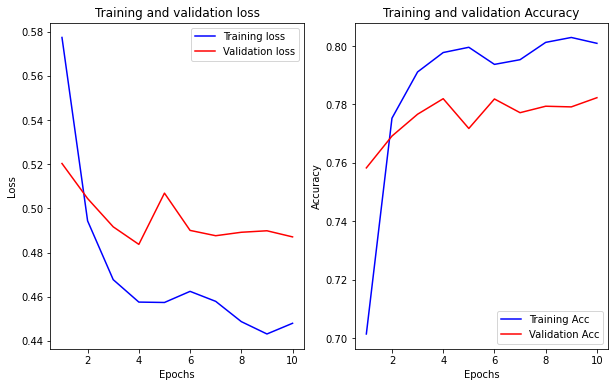

In [380]:
acc = w2v_pre_history_dict['accuracy']
val_acc = w2v_pre_history_dict['val_accuracy']
loss = w2v_pre_history_dict['loss']
val_loss = w2v_pre_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs = axes.ravel()

axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, acc, 'b', label='Training Acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation Acc')
axs[1].set_title('Training and validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


# Further TODO

## What about other models?

LSTM 레이어로 0.85를 달성하는 것은 쉬운 일이 아니였습니다. 무엇보다 지나치게 데이터를 잘 맞춰 오버피팅이 생겨서 문제가 됐습니다. 더군다나 regularization을 진행하면서도 세부 parameter를 조금씩 수정해가면서 0.848.. 쯤에서 0.85를 달성하기까지 지나치게 긴 시간이 걸렸습니다.
(_시간 관계상 GRU, SimpleRNN의 경우에 대해서는 regularization을 진행하지 못했습니다._)

텍스트 감성분석을 하는 데에 LSTM은 어느정도 한계가 있습니다. 다른 모델들은 어느 정도 성능이 나오는 지 찾아본 바에 의하면 다음과 같습니다. [source](https://github.com/monologg/KoBERT-nsmc#readme)

|Model|Accuracy(%)|
|---|---|
|KoBERT|<span style="color:red">89.63</span>|
|DistilKoBERT|88.41|
|Bert-Multilingual|87.07|
|FastText|85.50|


더 좋은 성능을 얻기 위해서는 사전학습이 더욱 잘 된 좋은 모델을 활용하는 것도 한가지 방법입니다. 몇개의 구현한 예제를 첨부해두겠습니다.

[BERT](http://yonghee.io/bert_binary_classification_naver/)

[KoBERT](https://github.com/monologg/KoBERT-nsmc#readme)

최근에는 이처럼 자연어 처리에 쓰이는 다양한 모델들이 생겨나고 있습니다. Transformer부터 시작해서 GPT-2, 3 등 엄청나게 많은 파라미터를 가진 모델들이 나오고 있는 상황입니다. 또한 [링크](https://www.facebook.com/groups/modulabs/posts/4232361280162356/)에 의하면 RNN - Transformer - CNN - MLP 순으로 서로를 대체해가며 발전하고 있는 상황이라고 합니다.

## How important preprocessing is

본 커널에서는 텍스트 데이터에 대해 많은 전처리를 진행하지 않았습니다. 하지만 한글을 다룰 때는 전처리가 꽤나 중요합니다. 더군다나 한글 말뭉치의 경우 다음 세 조건에 의해 성능이 많이 변하기도 합니다.

1. 띄어쓰기 교정유무
2. 맞춤법 교정유무
3. 형태소의 기준

따라서 띄어쓰기, 맞춤법에 대한 전처리를 생각해보고 진행해주는 것이 좋습니다. 이번 커널에서 진행은 했지만 불용어 처리에 대해서도 다시 한번 생각해보고 진행해주는 것도 필요합니다.

[한글 전처리](https://ebbnflow.tistory.com/246)